In [4]:
import os
import sys
sys.path.append('/home/yang_liu/python_workspace/3DGS')

import yaml
import torch
import torchvision
import torch_scatter
import wandb
import time
import inspect
import imageio
import numpy as np
import open3d as o3d
import pynvml
import matplotlib.pyplot as plt
from tqdm import tqdm
from arguments import GroupParams
from scene import LargeScene
from os import makedirs
from gaussian_renderer import render_lod, render
from utils.general_utils import safe_state
from utils.large_utils import which_block, block_filtering
from utils.sh_utils import SH2RGB
from argparse import ArgumentParser
from arguments import ModelParams, PipelineParams, get_combined_args
from gaussian_renderer import GaussianModel
from torch.utils.data import DataLoader
from utils.camera_utils import loadCamV2
from transforms3d.euler import mat2euler, euler2mat
from transforms3d.quaternions import mat2quat, quat2mat
from utils.general_utils import PILtoTorch
from scene.cameras import Camera
from scipy.spatial import ConvexHull
from matplotlib.backends.backend_agg import FigureCanvasAgg

WARNED = False

In [2]:
class BlockedGaussian:

    gaussians : GaussianModel

    def __init__(self, gaussians, lp, range=[0, 1], scale=1.0, compute_cov3D_python=False):
        self.cell_corners = []
        self.xyz = None
        self.feats = None
        self.max_sh_degree = lp.sh_degree
        self.device = gaussians.get_xyz.device
        self.compute_cov3D_python = compute_cov3D_python
        self.cell_ids = torch.zeros(gaussians.get_opacity.shape[0], dtype=torch.long, device=self.device)
        self.mask = torch.zeros(gaussians.get_opacity.shape[0], dtype=torch.bool, device=self.device)

        self.block_dim = lp.block_dim
        self.num_cell = lp.block_dim[0] * lp.block_dim[1] * lp.block_dim[2]
        self.aabb = lp.aabb
        self.scale = scale
        self.range = range

        self.cell_divider(gaussians)
        self.cell_corners = torch.stack(self.cell_corners, dim=0)

    def cell_divider(self, gaussians, n=4):
        with torch.no_grad():
            if self.compute_cov3D_python:
                geometry = gaussians.get_covariance(self.scale).to(self.device)
            else:
                geometry = torch.cat([gaussians.get_scaling,
                                      gaussians.get_rotation], dim=1)
            self.xyz = gaussians.get_xyz
            self.feats = torch.cat([gaussians.get_opacity,  
                                    gaussians.get_features.reshape(geometry.shape[0], -1),
                                    geometry], dim=1).half()
            
            for cell_idx in range(self.num_cell):
                cell_mask = block_filtering(cell_idx, self.xyz, self.aabb, self.block_dim, self.scale)
                self.cell_ids[cell_mask] = cell_idx
                # MAD to eliminate influence of outsiders
                xyz_median = torch.median(self.xyz[cell_mask], dim=0)[0]
                delta_median = torch.median(torch.abs(self.xyz[cell_mask] - xyz_median), dim=0)[0]
                xyz_min = xyz_median - n * delta_median
                xyz_min = torch.max(xyz_min, torch.min(self.xyz[cell_mask], dim=0)[0])
                xyz_max = xyz_median + n * delta_median
                xyz_max = torch.min(xyz_max, torch.max(self.xyz[cell_mask], dim=0)[0])
                corners = torch.tensor([[xyz_min[0], xyz_min[1], xyz_min[2]],
                                       [xyz_min[0], xyz_min[1], xyz_max[2]],
                                       [xyz_min[0], xyz_max[1], xyz_min[2]],
                                       [xyz_min[0], xyz_max[1], xyz_max[2]],
                                       [xyz_max[0], xyz_min[1], xyz_min[2]],
                                       [xyz_max[0], xyz_min[1], xyz_max[2]],
                                       [xyz_max[0], xyz_max[1], xyz_min[2]],
                                       [xyz_max[0], xyz_max[1], xyz_max[2]]], device=self.xyz.device)
                self.cell_corners.append(corners)
    
    def get_feats(self, indices, distances):
        out_xyz = torch.tensor([], device=self.device, dtype=self.xyz.dtype)
        out_feats = torch.tensor([], device=self.device, dtype=self.feats.dtype)
        block_mask = (distances >= self.range[0]) & (distances < self.range[1])
        if block_mask.sum() > 0:
            self.mask = torch.isin(self.cell_ids, indices[block_mask].to(self.device))
            out_xyz = self.xyz[self.mask]
            out_feats = self.feats[self.mask]
        return out_xyz, out_feats

    def get_feats_ptwise(self, viewpoint_cam):
        out_xyz = torch.tensor([], device=self.device, dtype=self.xyz.dtype)
        out_feats = torch.tensor([], device=self.device, dtype=self.feats.dtype)

        homo_xyz = torch.cat([self.xyz, torch.ones_like(self.xyz[..., [0]])], dim=-1)
        cam_center = viewpoint_cam.camera_center
        viewmatrix = viewpoint_cam.world_view_transform
        xyz_cam = homo_xyz @ viewmatrix
        self.mask = (xyz_cam[..., 2] > 0.2)
        if self.mask.sum() == 0:
            return out_xyz, out_feats

        distances = torch.norm(self.xyz - cam_center[None, :3], dim=-1)
        self.mask &= (distances >= self.range[0]) & (distances < self.range[1])
        if self.mask.sum() > 0:
            out_xyz = self.xyz[self.mask]
            out_feats = self.feats[self.mask]
        return out_xyz, out_feats

def load_gaussians(cfg, config_name, iteration=30_000, load_vq=False, device='cuda', source_path='data/matrix_city/aerial/test/block_all_test'):
    
    lp, op, pp = parse_cfg(cfg)
    setattr(lp, 'config_path', cfg)
    lp.source_path = source_path
    lp.model_path = os.path.join("../output/", config_name)

    modules = __import__('scene')
    
    with torch.no_grad():
        if 'apply_voxelize' in lp.model_config['kwargs'].keys():
            lp.model_config['kwargs']['apply_voxelize'] = False
        gaussians = getattr(modules, lp.model_config['name'])(lp.sh_degree, device=device, **lp.model_config['kwargs'])
        scene = LargeScene(lp, gaussians, load_iteration=iteration, load_vq=load_vq, shuffle=False)
        print(f'Init {config_name} with {len(gaussians.get_opacity)} points\n')

    return gaussians, scene

def parse_cfg(cfg):
    lp = GroupParams()
    op = GroupParams()
    pp = GroupParams()

    for arg in cfg['model_params'].items():
        setattr(lp, arg[0], arg[1])
    
    for arg in cfg['optim_params'].items():
        setattr(op, arg[0], arg[1]) 

    for arg in cfg['pipeline_params'].items():
        setattr(pp, arg[0], arg[1])
    
    return lp, op, pp

def loadCamV3(args, id, cam_info, resolution_scale, xyz=None, z_dim=None, yaw=None):
    # use appointed pitch and height
    orig_w, orig_h = cam_info.image.size

    if args.resolution in [1, 2, 4, 8]:
        resolution = round(orig_w/(resolution_scale * args.resolution)), round(orig_h/(resolution_scale * args.resolution))
    else:  # should be a type that converts to float
        if args.resolution == -1:
            if orig_w > 1600:
                global WARNED
                if not WARNED:
                    print("[ INFO ] Encountered quite large input images (>1.6K pixels width), rescaling to 1.6K.\n "
                        "If this is not desired, please explicitly specify '--resolution/-r' as 1")
                    WARNED = True
                global_down = orig_w / 1600
            else:
                global_down = 1
        else:
            global_down = orig_w / args.resolution

        scale = float(global_down) * float(resolution_scale)
        resolution = (int(orig_w / scale), int(orig_h / scale))

    resized_image_rgb = PILtoTorch(cam_info.image, resolution)

    gt_image = resized_image_rgb[:3, ...]
    loaded_mask = None

    if resized_image_rgb.shape[1] == 4:
        loaded_mask = resized_image_rgb[3:4, ...]

    if yaw is not None and z_dim is not None and xyz is not None:
        Rt = np.zeros((4, 4))
        Rt[:3, :3] = cam_info.R.transpose()
        Rt[:3, 3] = cam_info.T
        Rt[3, 3] = 1.0

        C2W = np.linalg.inv(Rt)
        euler = np.array(mat2euler(C2W[:3, :3]))
        euler[z_dim] = yaw
        C2W[:3, :3] = euler2mat(*euler)
        C2W[:3, 3] = xyz
        Rt = np.linalg.inv(C2W)

        R = Rt[:3, :3].transpose()
        T = Rt[:3, 3]
    else:
        R = cam_info.R
        T = cam_info.T

    return Camera(colmap_id=cam_info.uid, R=R, T=T, 
                  FoVx=cam_info.FovX, FoVy=cam_info.FovY, 
                  image=gt_image, gt_alpha_mask=loaded_mask,
                  image_name=cam_info.image_name, uid=id, data_device=args.data_device)

def loadCamV4(args, id, cam_info, resolution_scale, xyz=None, angle=None):
    # use appointed pitch and height
    orig_w, orig_h = cam_info.image.size

    if args.resolution in [1, 2, 4, 8]:
        resolution = round(orig_w/(resolution_scale * args.resolution)), round(orig_h/(resolution_scale * args.resolution))
    else:  # should be a type that converts to float
        if args.resolution == -1:
            if orig_w > 1600:
                global WARNED
                if not WARNED:
                    print("[ INFO ] Encountered quite large input images (>1.6K pixels width), rescaling to 1.6K.\n "
                        "If this is not desired, please explicitly specify '--resolution/-r' as 1")
                    WARNED = True
                global_down = orig_w / 1600
            else:
                global_down = 1
        else:
            global_down = orig_w / args.resolution

        scale = float(global_down) * float(resolution_scale)
        resolution = (int(orig_w / scale), int(orig_h / scale))

    resized_image_rgb = PILtoTorch(cam_info.image, resolution)

    gt_image = resized_image_rgb[:3, ...]
    loaded_mask = None

    if resized_image_rgb.shape[1] == 4:
        loaded_mask = resized_image_rgb[3:4, ...]

    if angle is not None and xyz is not None:
        Rt = np.zeros((4, 4))
        Rt[:3, :3] = cam_info.R.transpose()
        Rt[:3, 3] = cam_info.T
        Rt[3, 3] = 1.0

        C2W = np.linalg.inv(Rt)
        euler = np.array(mat2euler(C2W[:3, :3]))
        euler = angle
        C2W[:3, :3] = euler2mat(*euler)
        C2W[:3, 3] = xyz
        Rt = np.linalg.inv(C2W)

        R = Rt[:3, :3].transpose()
        T = Rt[:3, 3]
    else:
        R = cam_info.R
        T = cam_info.T

    return Camera(colmap_id=cam_info.uid, R=R, T=T, 
                  FoVx=cam_info.FovX, FoVy=cam_info.FovY, 
                  image=gt_image, gt_alpha_mask=loaded_mask,
                  image_name=cam_info.image_name, uid=id, data_device=args.data_device)

# find the a & b points
def get_bezier_coef(points):
    # since the formulas work given that we have n+1 points
    # then n must be this:
    n = len(points) - 1

    # build coefficents matrix
    C = 4 * np.identity(n)
    np.fill_diagonal(C[1:], 1)
    np.fill_diagonal(C[:, 1:], 1)
    C[0, 0] = 2
    C[n - 1, n - 1] = 7
    C[n - 1, n - 2] = 2

    # build points vector
    P = [2 * (2 * points[i] + points[i + 1]) for i in range(n)]
    P[0] = points[0] + 2 * points[1]
    P[n - 1] = 8 * points[n - 1] + points[n]

    # solve system, find a & b
    A = np.linalg.solve(C, P)
    B = [0] * n
    for i in range(n - 1):
        B[i] = 2 * points[i + 1] - A[i + 1]
    B[n - 1] = (A[n - 1] + points[n]) / 2

    return A, B

# returns the general Bezier cubic formula given 4 control points
def get_cubic(a, b, c, d):
    return lambda t: np.power(1 - t, 3) * a + 3 * np.power(1 - t, 2) * t * b + 3 * (1 - t) * np.power(t, 2) * c + np.power(t, 3) * d

# return one cubic curve for each consecutive points
def get_bezier_cubic(points):
    A, B = get_bezier_coef(points)
    return [
        get_cubic(points[i], A[i], B[i], points[i + 1])
        for i in range(len(points) - 1)
    ]

# evalute each cubic curve on the range [0, 1] sliced in n points
def evaluate_bezier(points, n):
    curves = get_bezier_cubic(points)
    seg_length = [np.linalg.norm(points[i] - points[i + 1]) for i in range(len(points) - 1)]
    mean_length = np.mean(np.array(seg_length))
    return np.array([fun(t) for length, fun in zip(seg_length, curves) for t in np.linspace(0, 1, max(int(n * length / mean_length), 1))])

def evaluate_bezier_v2(points, n):
    curves = get_bezier_cubic(points)
    seg_length = [np.linalg.norm(points[i] - points[i + 1]) for i in range(len(points) - 1)]
    mean_length = np.mean(np.array(seg_length))
    seg_pts_num = np.array([max(int(n * length / mean_length), 1) for length in seg_length])
    acc_pts_num = np.cumsum(seg_pts_num)
    pts = np.array([fun(t) for length, fun in zip(seg_length, curves) for t in np.linspace(0, 1, max(int(n * length / mean_length), 1))])
    return pts, acc_pts_num

def evaluate_bezier_v3(points, n):
    curves = get_bezier_cubic(points)
    seg_samples = [n]
    speed_start = None
    speed_end_pre = curves[0](1) - curves[0](1-1/n)
    for idx in range(1, len(curves)):
        speed_start = curves[idx](1/n) - curves[idx](0)
        n = int(n * np.linalg.norm(speed_start) / np.linalg.norm(speed_end_pre))
        seg_samples.append(n)
        speed_end_pre = curves[idx](1) - curves[idx](1-1/n)
        
    acc_pts_num = np.cumsum(np.array(seg_samples))
    pts = np.array([fun(t) for samples, fun in zip(seg_samples, curves) for t in np.linspace(0, 1, max(samples, 1))])
    return pts, acc_pts_num

def np_move_avg(a,n,mode="same"):
    b = a.copy()
    b[n//2:-n//2] = np.convolve(a, np.ones((n,))/n, mode=mode)[n//2:-n//2]
    return b

def np_move_avg_v2(a,n,mode="same"):
    b = a.copy()
    if len(b.shape) == 1:
        b[n//2:-n//2] = np.convolve(a, np.ones((n,))/n, mode=mode)[n//2:-n//2]
    else:
        for i in range(b.shape[1]):
            b[n//2:-n//2, i] = np.convolve(a[:, i], np.ones((n,))/n, mode=mode)[n//2:-n//2]
    return b

## 1. Render from training view

## 1.1 Use LoD

In [3]:
load_vq = True
iteration = 30_000
custom_test = '../data/mill19/rubble-pixsfm/train'
if load_vq:
    iteration = None

config = "../config/block_rubble_all_lr_c9_loss_12_r4_lod.yaml"
model_path = os.path.join('../output', os.path.basename(config).split('.')[0])
with open(config) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    lp, op, pp = parse_cfg(cfg)
    setattr(lp, 'config_path', config)
    if lp.model_path == '':
        lp.model_path = model_path

assert len(lp.lod_configs)-1 == len(lp.dist_threshold)
lp.dist_threshold = [0] + lp.dist_threshold + [1e6]

with torch.no_grad():
    lod_gs_list = []
    for i in range(len(lp.lod_configs)):
        config = os.path.join("..", lp.lod_configs[i])
        config_name = os.path.splitext(os.path.basename(config))[0]
        with open(config) as f:
            cfg = yaml.load(f, Loader=yaml.FullLoader)
        lod_gs, scene = load_gaussians(cfg, config_name, iteration, load_vq, source_path=custom_test)
        lod_gs = BlockedGaussian(lod_gs, lp, range=[lp.dist_threshold[i], lp.dist_threshold[i+1]], compute_cov3D_python=pp.compute_cov3D_python)
        lod_gs_list.append(lod_gs)

    if custom_test:
        lp.source_path = custom_test
        filename = os.path.basename(lp.source_path)

    bg_color = [1,1,1] if lp.white_background else [0, 0, 0]
    background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
    
    if custom_test:
        views = scene.getTrainCameras() + scene.getTestCameras()

Reading camera 1657/1657
Init block_rubble_all_lr_c9_loss_12_r4_40_lr64_vq with 5844738 points



/home/yang_liu/python_workspace/3DGS/utils/large_utils.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xyz_tensor = torch.tensor(xyz_org)


Reading camera 1657/1657
Init block_rubble_all_lr_c9_loss_12_r4_50_lr64_vq with 4870615 points

Reading camera 1657/1657
Init block_rubble_all_lr_c9_loss_12_r4_60_lr64_vq with 3896492 points



In [9]:
cam_center_list = []
for idx in range(len(views)):
    viewpoint_cam = loadCamV2(lp, idx, views[idx], 1.0, -180, None)
    cam_center_list.append(viewpoint_cam.camera_center.detach().cpu().numpy())

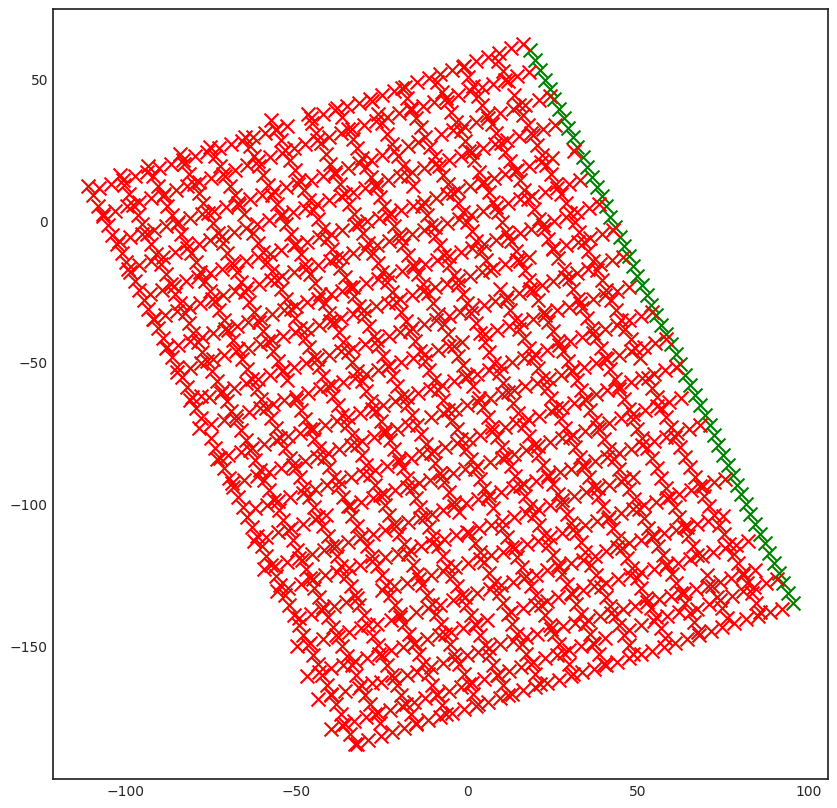

In [60]:
plt.style.use('seaborn-white')
plt.figure(figsize=(10, 10))
for idx in range(len(views)):
    color = 'r'
    if 0 <= idx < 57:
        color = 'g'
    cam_center = cam_center_list[idx]
    plt.scatter(cam_center[0], cam_center[2], s=100, c=color, marker='x')
    # plt.text(cam_center[0], cam_center[1], f'{idx}', fontsize=12)

# cam_centers = np.array(cam_center_list)
# pose1_center = cam_centers[np.where(cam_centers[:, 2] == cam_centers[:, 2].max())]
# pose2_center = cam_centers[np.where(cam_centers[:, 0] == cam_centers[:, 0].max())]
# pose3_center = cam_centers[np.where(cam_centers[:, 2] == cam_centers[:, 2].min())]
# pose4_center = cam_centers[np.where(cam_centers[:, 0] == cam_centers[:, 0].min())]

# plt.scatter(pose1_center[0][0], pose1_center[0][2], s=100, c='b', marker='x')
# plt.text(pose1_center[0][0], pose1_center[0][2], '1', fontsize=12)
# plt.scatter(pose2_center[0][0], pose2_center[0][2], s=100, c='b', marker='x')
# plt.text(pose2_center[0][0], pose2_center[0][2], '2', fontsize=12)
# plt.scatter(pose3_center[0][0], pose3_center[0][2], s=100, c='b', marker='x')
# plt.text(pose3_center[0][0], pose3_center[0][2], '3', fontsize=12)
# plt.scatter(pose4_center[0][0], pose4_center[0][2], s=100, c='b', marker='x')
# plt.text(pose4_center[0][0], pose4_center[0][2], '4', fontsize=12)

In [93]:
# find corner poses
cam_centers = np.array(cam_center_list)
pose1_center = cam_centers[np.where(cam_centers[:, 2] == cam_centers[:, 2].max())]
pose2_center = cam_centers[np.where(cam_centers[:, 0] == cam_centers[:, 0].max())]
pose3_center = cam_centers[np.where(cam_centers[:, 2] == cam_centers[:, 2].min())]
pose4_center = cam_centers[np.where(cam_centers[:, 0] == cam_centers[:, 0].min())]

scale_factor = 0.6
region_center = (pose1_center[0] + pose2_center[0] + pose3_center[0] + pose4_center[0]) / 4
pose1_center = region_center + scale_factor * (pose1_center[0] - region_center)
pose2_center = region_center + scale_factor * (pose2_center[0] - region_center)
pose3_center = region_center + scale_factor * (pose3_center[0] - region_center)
pose4_center = region_center + scale_factor * (pose4_center[0] - region_center)

pose1 = views[np.where(cam_centers[:, 2] == cam_centers[:, 2].max())[0].item()]
pose2 = views[np.where(cam_centers[:, 0] == cam_centers[:, 0].max())[0].item()]
pose3 = views[np.where(cam_centers[:, 2] == cam_centers[:, 2].min())[0].item()]
pose4 = views[np.where(cam_centers[:, 0] == cam_centers[:, 0].min())[0].item()]

poses = [pose1, pose2, pose3, pose4, pose1, pose2]
pose_centers = [pose1_center, pose2_center, pose3_center, pose4_center, pose1_center, pose2_center]

video_path = os.path.join(model_path, config_name, "ours_lod_video")
makedirs(video_path, exist_ok=True)
frames = []

for idx in range(len(poses) - 2):
    angle = np.arctan2(pose_centers[idx+1][2] - pose_centers[idx][2], pose_centers[idx+1][0] - pose_centers[idx][0]) + np.pi / 2

    # print("Current Anlge: ", angle * 180 / np.pi)
    step = 0.005
    for t in np.arange(0, 1 + step, step):
        xyz = (1 - t) * pose_centers[idx] + t * pose_centers[idx+1]
        viewpoint_cam = loadCamV3(lp, idx, poses[idx], 1.0, xyz=xyz, z_dim=1, yaw=angle)
        img = render_lod(viewpoint_cam, lod_gs_list, pp, background)["render"]
        img = (img * 255).clamp(0, 255).to(torch.uint8).permute(1, 2, 0).cpu().numpy()
        frames.append(img)

    
    step=0.02
    angle_next = np.arctan2(pose_centers[idx+2][2] - pose_centers[idx+1][2], pose_centers[idx+2][0] - pose_centers[idx+1][0]) + np.pi / 2

    if np.abs(angle_next - angle) > np.pi:
        if angle_next > angle:
            angle_next -= 2 * np.pi
        else:
            angle_next += 2 * np.pi
    # print("Next Anlge: ", angle_next * 180 / np.pi, "\n")
    for t in np.arange(step, 1, step):
        angle_tmp = (1 - t) * angle + t * angle_next
        viewpoint_cam = loadCamV3(lp, idx, poses[idx], 1.0, xyz=xyz, z_dim=1, yaw=angle_tmp)
        img = render_lod(viewpoint_cam, lod_gs_list, pp, background)["render"]
        img = (img * 255).clamp(0, 255).to(torch.uint8).permute(1, 2, 0).cpu().numpy()
        frames.append(img)

In [94]:
video = imageio.get_writer(os.path.join(video_path, "video.mp4"), mode="I", fps=30, codec="libx264", bitrate="16M", quality=10)
for frame in frames:
    video.append_data(frame)
video.close()
print(f'Video saved to {video_path}')

Video saved to ../output/block_rubble_all_lr_c9_loss_12_r4_lod/block_rubble_all_lr_c9_loss_12_r4_60_lr64_vq/ours_lod_video


## 1.2 No LoD, MatrixCity

In [3]:
load_vq = True
iteration = 30_000
custom_test = '../data/matrix_city/aerial/test/block_all_test'
if load_vq:
    iteration = None

config = "../config/block_mc_aerial_block_all_lr_c36_loss_5_50_lr64_vq.yaml"
model_path = os.path.join('../output', os.path.basename(config).split('.')[0])
with open(config) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    lp, op, pp = parse_cfg(cfg)
    setattr(lp, 'config_path', config)
    if lp.model_path == '':
        lp.model_path = model_path

with torch.no_grad():
    modules = __import__('scene')
    model_config = lp.model_config
    gaussians = getattr(modules, model_config['name'])(lp.sh_degree, **model_config['kwargs'])

    if custom_test:
        lp.source_path = custom_test
        filename = os.path.basename(lp.source_path)
    scene = LargeScene(lp, gaussians, load_iteration=iteration, load_vq=load_vq, shuffle=False)

    bg_color = [1,1,1] if lp.white_background else [0, 0, 0]
    background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
    
    if custom_test:
        views = scene.getTrainCameras() + scene.getTestCameras()

org_scaling = gaussians._scaling.clone()
org_opacity = gaussians._opacity.clone()

Reading camera 741/741


In [4]:
cam_center_list = []
dim = 1
for idx in range(len(views)):
    Rt = np.zeros((4, 4))
    Rt[:3, :3] = views[idx].R.transpose()
    Rt[:3, 3] = views[idx].T
    Rt[3, 3] = 1.0

    C2W = np.linalg.inv(Rt)
    cam_center_list.append(C2W[:3, -1])

### 1.2.1 Get Convex Hull of Training / Test Poses

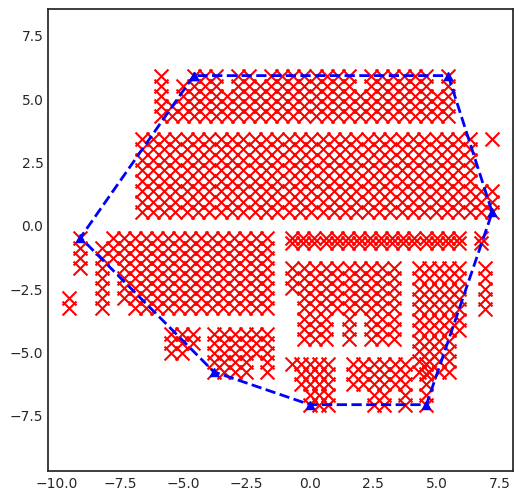

In [6]:
plt.style.use('seaborn-white')
plt.figure(figsize=(6, 6))
plt.axis('equal')
for idx in range(len(views)):
    color = 'r'
    cam_center = cam_center_list[idx]
    plt.scatter(cam_center[0], cam_center[dim], s=100, c=color, marker='x')
    # plt.text(cam_center[0], cam_center[1], f'{idx}', fontsize=12)

cam_center_array = np.array(cam_center_list)
hull = ConvexHull(np.array(cam_center_array)[:, [0, dim]], 'Qg')
hull_list=hull.vertices.tolist()

simplified_hull = []
dist = 3
for idx in range(len(hull_list)):
    dist_1 = np.linalg.norm(cam_center_array[hull_list[idx], [0, dim]] - cam_center_array[hull_list[idx-1], [0, dim]])
    if dist_1 > dist:
        simplified_hull.append(hull_list[idx])
        
simplified_hull = simplified_hull[2:] + simplified_hull[:2]
simplified_hull.append(simplified_hull[0])

plt.plot(cam_center_array[simplified_hull,0], cam_center_array[simplified_hull, dim], 'b--^',lw=2)

### 1.2.2 Fly Around the Whole Scene

In [6]:
# find corner poses
pose_centers = cam_center_array[simplified_hull]
poses = [views[i] for i in simplified_hull]

scale_factor = 0.8
region_center = np.mean(pose_centers, axis=0)
pose_centers = region_center + scale_factor * (pose_centers - region_center)
pose_centers = np.vstack((pose_centers, pose_centers[0]))

video_path = os.path.join(lp.model_path, filename, "ours_lod_video")
makedirs(video_path, exist_ok=True)
frames = []
pose_per_segment = 50

# second parameter appoints number of points interpolated between each consecutive points to draw the curve
interp_xyz = evaluate_bezier(pose_centers, pose_per_segment)
xyz_pre = None

fontsize = 20
fig = plt.Figure(figsize=(12, 9), dpi=100)
fig.set_tight_layout(True)
canvas = FigureCanvasAgg(fig)
ax = fig.gca()
gs_xyz = gaussians.get_xyz.cpu().detach().numpy()
ax.scatter(gs_xyz[::200, 0], gs_xyz[::200, dim], c='dimgrey', s=0.5)
# ax.plot(cam_center_array[simplified_hull,0], cam_center_array[simplified_hull, dim], 'r--^',lw=2)
ax.axis('equal')
ax.set_xlabel('x/100m', fontsize=fontsize)
ax.set_ylabel('y/100m', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_xlim(np.min(cam_center_array[:, 0]), np.max(cam_center_array[:, 0]))
ax.set_ylim(np.min(cam_center_array[:, dim]), np.max(cam_center_array[:, dim]))

plt.style.use('seaborn-white')
for t in range(len(interp_xyz)):
    xyz = interp_xyz[t]

    if t == 0:
        delta = interp_xyz[t + 1] - interp_xyz[t]
    else:
        delta = xyz - xyz_pre
    
    if not np.any(delta):
        continue
    
    ax.scatter(xyz[0], xyz[dim], s=100, c='r', marker='x', label='poses')
    if t == 0:
        ax.legend(fontsize=fontsize)
    canvas.draw()
    buf = canvas.buffer_rgba()
    bev_map = np.asarray(buf)[..., :3]

    angle = np.arctan2(delta[dim], delta[0])

    # for matrix city, z_dim=2, otherwise z_dim=1
    viewpoint_cam = loadCamV3(lp, idx, poses[0], 1.0, xyz=xyz, z_dim=2, yaw=angle)
    img = render(viewpoint_cam, gaussians, pp, background)["render"]
    img = (img * 255).clamp(0, 255).to(torch.uint8).permute(1, 2, 0).cpu().numpy()

    img = np.concatenate([img, bev_map], axis=1)
    
    frames.append(img)

    xyz_pre = xyz

plt.imshow(bev_map)
plt.axis('off')

[ INFO ] Encountered quite large input images (>1.6K pixels width), rescaling to 1.6K.
 If this is not desired, please explicitly specify '--resolution/-r' as 1


KeyboardInterrupt: 

### 1.2.3 Fly Around Certain Point

In [30]:
xyz = gaussians.get_xyz.cpu().detach().numpy()
# mask = ((xyz[:, 0] < -3.5) & (xyz[:, 2] > 1.0)) | ((xyz[:, 0] >= -3.5) & (xyz[:, 0] < -0.8) & (xyz[:, 2] > 1.4)) | \
#            ((xyz[:, 0] > 5.0) & (xyz[:, 2] > 2.2))

pose_centers = np.array([
    [3.2, 5.8, 3.5],
    [1.2, 3.8, 2.5],
    [3.2, 1.8, 1.8],
    [5.2, 3.8, 2.5],
    [3.2, 5.8, 3.5],
    [-3.0, 4.1, 5.0],
    [-7.37, -0.46, 5.0],
    [-3.16, -4.7,  6.0],
    [3.5, -5.74, 5.0],
    [7, -2, 5.0],
    [5.0, 1.0, 3.0],
    [2.0, 0.5, 2.0],
    [-3.0, 2.9, 2.0],
    [-5.5, 1.2, 2.0],
    [-4.0, -1, 3.5],
    [1.0, 0.0, 6],
    [3.5, -1.8, 5.5],
    [1.0, -3.6, 4.5],
    [0.5, 0, 6],
    [0.5, 0, 10],
    [0.5, 0, 15],
])

interp_xyz, acc_pts = evaluate_bezier_v3(pose_centers, 25)  # fixed as 50 for fast floater removement
mask = np.zeros(len(xyz), dtype=bool)
threhsold = 1.75

# one interp point to all gs
# for idx in tqdm(range(len(interp_xyz))):
#     distance = np.linalg.norm(interp_xyz[None, idx] - xyz, axis=1)
#     sorted_dist = np.sort(distance)
#     if sorted_dist[0] < threhsold and sorted_dist[:10].mean() > 1.5 * threhsold:
#         mask[distance < threhsold] = True

# one gs to all interp points
for idx in tqdm(range(len(xyz))):
    distance = np.linalg.norm(xyz[None, idx] - interp_xyz, axis=1)
    mask[idx] = np.min(distance) < threhsold

# plt.figure()
# plt.style.use('seaborn-white')
# plt.axis('equal')
# plt.scatter(xyz[::500, 0], xyz[::500, 2], c='dimgrey', s=0.5)
# # plt.plot([5, 5], [-5, 10], 'r--')
# plt.plot([-10, 8], [2.2, 2.2], 'r--')
# plt.xlim(-9, 8)
# # plt.ylim(-8, 8)
# plt.ylim(0, 5)

100%|██████████| 11782801/11782801 [04:38<00:00, 42379.05it/s]


In [31]:
with torch.no_grad():
    gaussians._scaling = org_scaling.clone()
    gaussians._opacity = org_opacity.clone()
    gaussians._scaling[mask] = -1e6
    gaussians._opacity[mask] = -1e6

In [32]:
# find corner poses
region_center1 = np.array([3.2, 2.8, 2.5])
region_center2 = np.array([1.4, -2.75, 5.0])
radius = 2

poses = [views[i] for i in simplified_hull]

video_path = os.path.join(lp.model_path, filename, "ours_lod_video")
makedirs(video_path, exist_ok=True)

# second parameter appoints number of points interpolated between each consecutive points to draw the curve
xyz_pre = None

fontsize = 20
fig = plt.Figure(figsize=(12, 9), dpi=100)
fig.set_tight_layout(True)
canvas = FigureCanvasAgg(fig)
ax = fig.gca()
gs_xyz = gaussians.get_xyz.cpu().detach().numpy()
ax.scatter(gs_xyz[::200, 0], gs_xyz[::200, dim], c='dimgrey', s=0.5)
# ax.plot(cam_center_array[simplified_hull,0], cam_center_array[simplified_hull, dim], 'r--^',lw=2)
ax.axis('equal')
ax.set_xlabel('x/100m', fontsize=fontsize)
ax.set_ylabel('y/100m', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_xlim(np.min(cam_center_array[:, 0]), np.max(cam_center_array[:, 0]))
ax.set_ylim(np.min(cam_center_array[:, dim]), np.max(cam_center_array[:, dim]))

# First Stage, fly around certain point

# step = 0.01
# plt.style.use('seaborn-white')
# for t in np.arange(0, 1+step, step):
#     xyz = region_center2.copy()
#     xyz[0] += (radius + 1.0 * np.cos(2 * np.pi * t)) * np.cos(2 * np.pi * t + np.pi / 2)
#     xyz[dim] += (radius + 1.0 * np.cos(2 * np.pi * t)) * np.sin(2 * np.pi * t + np.pi / 2)

#     xyz[2] += 1.0 * np.cos(2 * np.pi * t)

#     if t == 0 or t == 0.25 or t == 0.5 or t == 0.75 or t == 1:
#         print(f"Current Position: {xyz}")

#     delta = region_center2 - xyz
    
#     if not np.any(delta):
#         continue
    
#     ax.scatter(xyz[0], xyz[dim], s=100, c='r', marker='x', label='poses')
#     if t == 0:
#         ax.legend(fontsize=fontsize)
#     # canvas.draw()
#     # buf = canvas.buffer_rgba()
#     # bev_map = np.asarray(buf)[..., :3]

#     angle = np.arctan2(-delta[0], delta[dim])

#     # for matrix city, z_dim=2, otherwise z_dim=1
#     viewpoint_cam = loadCamV3(lp, idx, poses[0], 1.0, xyz=xyz, z_dim=2, yaw=angle)
#     img = render(viewpoint_cam, gaussians, pp, background)["render"]
#     img = (img * 255).clamp(0, 255).to(torch.uint8).permute(1, 2, 0).cpu().numpy()

#     # img = np.concatenate([img, bev_map], axis=1)
    
#     frames.append(img)

#     xyz_pre = xyz

# Second Stage, fly around the whole scene

pose_per_segment = 25
pose_centers = np.array([
    [3.2, 5.8, 3.5],
    [1.2, 3.8, 2.5],
    [3.2, 1.8, 1.8],
    [5.2, 3.8, 2.5],
    [3.2, 5.8, 3.5],
    [-3.0, 4.1, 5.0],
    [-7.37, -0.46, 5.0],
    [-3.16, -4.7,  6.0],
    [3.5, -5.74, 5.0],
    [7, -2, 5.0],
    [5.0, 1.0, 3.0],
    [2.0, 0.5, 2.0],
    [-3.0, 2.9, 2.0],
    [-5.5, 1.2, 2.0],
    [-4.0, -1, 3.5],
    [1.0, 0.0, 6],
    [3.5, -1.8, 5.5],
    [1.0, -3.6, 4.5],
    [0.5, 0, 6],
    [0.5, 0, 10],
    [0.5, 0, 15],
])

interp_xyz, acc_pts = evaluate_bezier_v3(pose_centers, pose_per_segment)

Rt = np.zeros((4, 4))
Rt[:3, :3] = poses[0].R.transpose()
Rt[:3, 3] = poses[0].T
Rt[3, 3] = 1.0

C2W = np.linalg.inv(Rt)
ref_angle = np.array(mat2euler(C2W[:3, :3]))

key_point1, interval1 = acc_pts[3], 10
key_point2, interval2 = acc_pts[9], 50
key_point3, interval3 = acc_pts[14], 50
key_point4, interval4 = acc_pts[17], 50
# key_point2, interval2 = acc_pts[2], 50
# key_point3, interval3 = acc_pts[7], 50
# key_point4, interval4 = acc_pts[10], 50
xyz_pre = None


xyz_list, angle_list = [], []

for t in range(len(interp_xyz)):
    xyz = interp_xyz[t]
    angle = ref_angle.copy()

    if xyz_pre is not None and not np.any(xyz - xyz_pre):
        continue

    if t < key_point1 - 10:
        # stage 1
        delta = region_center1 - xyz
        angle[2] = np.arctan2(delta[0], -delta[dim]) + np.pi
        
    elif t < key_point1:
        # transition
        delta = region_center1 - xyz
        angle2 = np.arctan2(delta[0], -delta[dim]) + np.pi

        delta = xyz - xyz_pre
        angle1 = np.arctan2(delta[dim], delta[0])

        angle[2] = (1 - (t - key_point1 + interval1 + 1) / interval1) * angle2 + (t - key_point1 + interval1 + 1) / interval1 * angle1

        # print(f"circle: {angle2}, org: {angle1}, current: {angle}")
    
    elif t < key_point2 - interval2:
        # stage 2

        if xyz_pre is None:
            delta = interp_xyz[t + 1] - interp_xyz[t]
        else:
            delta = xyz - xyz_pre
        
        # delta = xyz - xyz_pre
        angle[2] = np.arctan2(delta[dim], delta[0])

    elif t < key_point2:
        delta = xyz - xyz_pre
        angle2 = np.arctan2(delta[dim], delta[0])
        angle1 = np.arctan2(-delta[0], delta[dim])
        
        angle[2] = (1 - (t - key_point2 + interval2 + 1) / interval2) * angle2 + (t - key_point2 + interval2 + 1) / interval2 * angle1

    elif t < key_point3 - interval3:
        # stage 2
        delta = xyz - xyz_pre
        angle[2] = np.arctan2(-delta[0], delta[dim])

    elif t < key_point3:
        # transition
        
        delta = xyz - xyz_pre
        angle2 = np.arctan2(-delta[0], delta[dim])

        delta = region_center2 - xyz
        angle1 = np.arctan2(delta[0], -delta[dim]) - np.pi

        angle[2] = (1 - (t - key_point3 + interval3 + 1) / interval3) * angle2 + (t - key_point3 + interval3 + 1) / interval3 * angle1
    
    elif t < key_point4 - interval4:
        # stage 3
        delta = region_center2 - xyz
        angle[2] = np.arctan2(delta[0], -delta[dim]) - np.pi
    
    elif t < key_point4:
        # transition
        delta = region_center2 - xyz
        angle[2] = np.arctan2(delta[0], -delta[dim]) - np.pi

        angle[0] = (1 - (t - key_point4 + interval4 + 1) / interval4) * angle[0] + (t - key_point4 + interval4 + 1) / interval4 * (-np.pi)
    
    else:
        # stage 3
        delta = region_center2 - xyz
        angle[2] = np.arctan2(delta[0], -delta[dim]) - np.pi
        angle[0] = -np.pi

    xyz_list.append(xyz)
    angle_list.append(angle)

    xyz_pre = xyz

angle_list = np_move_avg_v2(np.unwrap(np.array(angle_list), axis=0), 10, mode='same').tolist()

frames = []
for t in range(len(xyz_list)):
    xyz = xyz_list[t]
    angle = angle_list[t]

    ax.scatter(xyz[0], xyz[dim], s=100, c='r', marker='x', label='poses')

    if t == 0:
        ax.legend(fontsize=fontsize)
    
    # canvas.draw()
    # buf = canvas.buffer_rgba()
    # bev_map = np.asarray(buf)[..., :3]

    # for matrix city, z_dim=2, otherwise z_dim=1
    viewpoint_cam = loadCamV4(lp, idx, poses[0], 1.0, xyz=xyz, angle=angle)
    img = render(viewpoint_cam, gaussians, pp, background)["render"]
    img = (img * 255).clamp(0, 255).to(torch.uint8).permute(1, 2, 0).cpu().numpy()

    # img = np.concatenate([img, bev_map], axis=1)
    
    frames.append(img) 

# canvas.draw()
# buf = canvas.buffer_rgba()
# bev_map = np.asarray(buf)[..., :3]
# plt.imshow(bev_map)
# plt.axis('off')

# plt.figure()
# plt.plot(np.array(angle_list)[:, 2] * 180 / np.pi)

### 1.2.4 Straight Line

In [9]:
# find corner poses
selected_poses = [simplified_hull[0]] + [simplified_hull[4]]
pose_centers = cam_center_array[selected_poses]
poses = [views[i] for i in selected_poses]

scale_factor = 0.5
region_center = np.mean(pose_centers, axis=0)
pose_centers = region_center + scale_factor * (pose_centers - region_center)
pose_centers = np.vstack((pose_centers, pose_centers[0]))

video_path = os.path.join(lp.model_path, filename, "ours_lod_video")
makedirs(video_path, exist_ok=True)
frames = []
pose_per_segment = 50

# second parameter appoints number of points interpolated between each consecutive points to draw the curve
interp_xyz = evaluate_bezier(pose_centers, pose_per_segment)
xyz_pre = None

fontsize = 20
fig = plt.Figure(figsize=(12, 9), dpi=100)
fig.set_tight_layout(True)
canvas = FigureCanvasAgg(fig)
ax = fig.gca()
gs_xyz = gaussians.get_xyz.cpu().detach().numpy()
ax.scatter(gs_xyz[::200, 0], gs_xyz[::200, dim], c='dimgrey', s=0.5)
# ax.plot(cam_center_array[simplified_hull,0], cam_center_array[simplified_hull, dim], 'r--^',lw=2)
ax.axis('equal')
ax.set_xlabel('x/100m', fontsize=fontsize)
ax.set_ylabel('y/100m', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_xlim(np.min(cam_center_array[:, 0]), np.max(cam_center_array[:, 0]))
ax.set_ylim(np.min(cam_center_array[:, dim]), np.max(cam_center_array[:, dim]))

plt.style.use('seaborn-white')
for t in range(len(interp_xyz)):
    xyz = interp_xyz[t]

    if t == 0:
        delta = interp_xyz[t + 1] - interp_xyz[t]
    else:
        delta = xyz - xyz_pre
    
    if not np.any(delta):
        continue
    
    ax.scatter(xyz[0], xyz[dim], s=100, c='r', marker='x', label='poses')
    if t == 0:
        ax.legend(fontsize=fontsize)
    canvas.draw()
    buf = canvas.buffer_rgba()
    bev_map = np.asarray(buf)[..., :3]

    angle = np.arctan2(-delta[0], delta[dim])

    # for matrix city, z_dim=2, otherwise z_dim=1
    viewpoint_cam = loadCamV3(lp, idx, poses[0], 1.0, xyz=xyz, z_dim=2, yaw=angle)
    img = render(viewpoint_cam, gaussians, pp, background)["render"]
    img = (img * 255).clamp(0, 255).to(torch.uint8).permute(1, 2, 0).cpu().numpy()

    img = np.concatenate([img, bev_map], axis=1)
    
    frames.append(img)

    xyz_pre = xyz

### 1.2.5 Save Video

In [33]:
video = imageio.get_writer(os.path.join(video_path, "video.mp4"), mode="I", fps=30, codec="libx264", bitrate="16M", quality=10)
for frame in frames:
    video.append_data(frame)
video.close()
print(f'Video saved to {video_path}')

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1600, 900) to (1600, 912) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video saved to ../output/block_mc_aerial_block_all_lr_c36_loss_5_50_lr64_vq/block_all_test/ours_lod_video


## 1.3 No LoD, Other Scene

In [128]:
load_vq = False
iteration = 30_000
custom_test = '../data/urban_scene_3d/sci-art-pixsfm/train'
if load_vq:
    iteration = None

config = "../config/block_sciart_all_lr_c9_loss_5_r4.yaml"
model_path = os.path.join('../output', os.path.basename(config).split('.')[0])
with open(config) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    lp, op, pp = parse_cfg(cfg)
    setattr(lp, 'config_path', config)
    if lp.model_path == '':
        lp.model_path = model_path

with torch.no_grad():
    modules = __import__('scene')
    model_config = lp.model_config
    gaussians = getattr(modules, model_config['name'])(lp.sh_degree, **model_config['kwargs'])

    if custom_test:
        lp.source_path = custom_test
        filename = os.path.basename(lp.source_path)
    scene = LargeScene(lp, gaussians, load_iteration=iteration, load_vq=load_vq, shuffle=False)

    bg_color = [1,1,1] if lp.white_background else [0, 0, 0]
    background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
    
    if custom_test:
        views = scene.getTrainCameras() + scene.getTestCameras()
    
    org_scaling = gaussians._scaling.clone()
    org_opacity = gaussians._opacity.clone()

Loading trained model at iteration 30000
Reading camera 2998/2998


In [290]:
with torch.no_grad():
    voxel_size = torch.tensor([10, 10])
    xy_range = torch.tensor([-200, -200, 150, 100])
    org_xyz = gaussians.get_xyz.cpu()
    voxel_index = torch.div(torch.tensor(org_xyz[:, [0, 2]]).float() - xy_range[None, :2], voxel_size[None, :], rounding_mode='floor')
    voxel_coords = voxel_index * voxel_size[None, :] + xy_range[None, :2] + voxel_size[None, :] / 2
    voxel_dim = torch.tensor([int((xy_range[2] - xy_range[0]) / voxel_size[0]), int((xy_range[3] - xy_range[1]) / voxel_size[1])])
    print(f"Dimension of Voxels: {voxel_dim}")

    new_coors, unq_inv, unq_cnt = torch.unique(voxel_coords, return_inverse=True, return_counts=True, dim=0)
    feat_mean = torch_scatter.scatter(org_xyz[:, 1], unq_inv, dim=0, reduce='mean')
    feat_std = torch_scatter.scatter_std(org_xyz[:, 1], unq_inv, dim=0)

/home/yang_liu/anaconda3/envs/gaussian_splatting/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


Dimension of Voxels: tensor([35, 30])


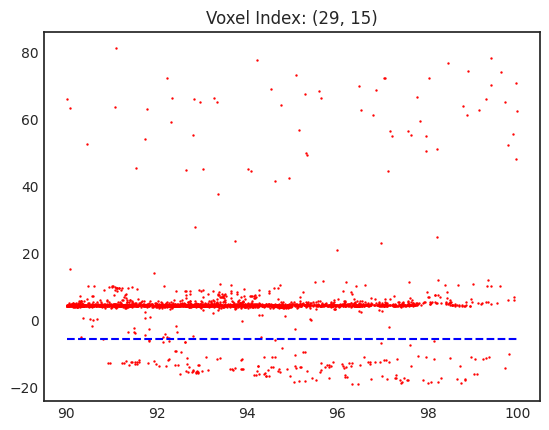

In [291]:
with torch.no_grad():
    feat = feat_mean - 1 * feat_std
    feat_inv = feat[unq_inv]
    mask = org_xyz[:, 1] < feat_inv

rand_x, rand_y = np.random.randint(0, voxel_dim[0]), np.random.randint(0, voxel_dim[1])
vox_mask = (voxel_index[:, 0] == rand_x) & (voxel_index[:, 1] == rand_y)

if vox_mask.sum() == 0:
    print(f"No points in voxel ({rand_x}, {rand_y})")
else:
    z_max = feat[unq_inv[vox_mask][0]]

    plt.figure()
    plt.style.use('seaborn-white')
    # plt.axis('equal')
    # plt.scatter(org_xyz[::500, 0], org_xyz[::500, 2], c='dimgrey', s=0.5)
    plt.scatter(org_xyz[vox_mask, 0], org_xyz[vox_mask, 1], c='r', s=0.5)
    plt.plot([org_xyz[vox_mask, 0].min(), org_xyz[vox_mask, 0].max()], [z_max, z_max], 'b--')
    plt.title(f'Voxel Index: ({rand_x}, {rand_y})')
    # plt.xlim(-200, 150)
    # plt.ylim(-200, 100)

(-250.0, 125.0)

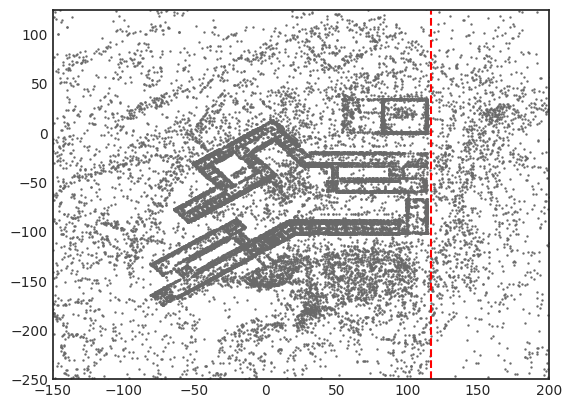

In [308]:
xyz = gaussians.get_xyz.cpu().detach().numpy()
rot_xz_angle = -37 * np.pi / 180  # 21 for residence, -37 for sci-art
rot_mat = np.array([[np.cos(rot_xz_angle), 0, np.sin(rot_xz_angle)], [0, 1, 0], [-np.sin(rot_xz_angle), 0, np.cos(rot_xz_angle)]])
xyz = np.dot(xyz, rot_mat.T)
plt.figure()
plt.style.use('seaborn-white')
# plt.axis('equal')
plt.scatter(xyz[::100, 0], xyz[::100, 2], c='dimgrey', s=0.5)
plt.plot([117, 117], [-250, 125], 'r--')
plt.xlim(-150, 200)
plt.ylim(-250, 125)

In [309]:
with torch.no_grad():
    # mask = (xyz[:, 1] < 20)  # rubble
    # mask = (xyz[:, 1] < 35) & (xyz[:, 0] < -15)  # building
    mask = (xyz[:, 1] < 30) & ((xyz[:, 0] > -150) & (xyz[:, 0] < 200) & (xyz[:, 2] > -250) & (xyz[:, 2] < 125)) \
           & ~((xyz[:, 0] > 80) & (xyz[:, 0] < 117) & (xyz[:, 2] > -4) & (xyz[:, 2] < 37))  # sci-art
    gaussians._scaling = org_scaling.clone()
    gaussians._opacity = org_opacity.clone()
    gaussians._scaling[mask] = -1e6
    gaussians._opacity[mask] = -1e6

In [310]:
cam_center_list = []
dim = 2
for idx in range(len(views)):
    Rt = np.zeros((4, 4))
    Rt[:3, :3] = views[idx].R.transpose()
    Rt[:3, 3] = views[idx].T
    Rt[3, 3] = 1.0

    C2W = np.linalg.inv(Rt)
    cam_center_list.append(C2W[:3, -1])
cam_center_array = np.array(cam_center_list)

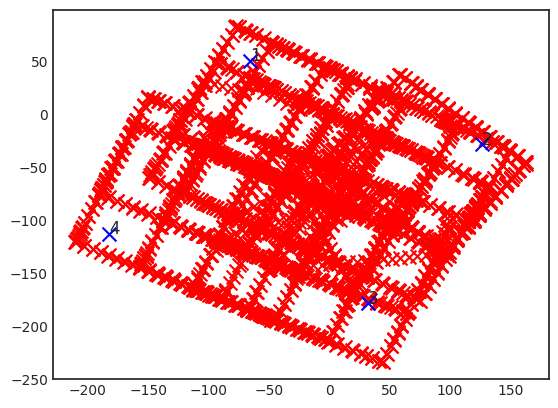

In [311]:
cam_centers = np.array(cam_center_list)
pose1_center = cam_centers[np.where(cam_centers[:, 2] == cam_centers[:, 2].max())]
pose2_center = cam_centers[np.where(cam_centers[:, 0] == cam_centers[:, 0].max())]
pose3_center = cam_centers[np.where(cam_centers[:, 2] == cam_centers[:, 2].min())]
pose4_center = cam_centers[np.where(cam_centers[:, 0] == cam_centers[:, 0].min())]

scale_factor = 0.8
region_center = (pose1_center[0] + pose2_center[0] + pose3_center[0] + pose4_center[0]) / 4
pose1_center = region_center + scale_factor * (pose1_center[0] - region_center)
pose2_center = region_center + scale_factor * (pose2_center[0] - region_center)
pose3_center = region_center + scale_factor * (pose3_center[0] - region_center)
pose4_center = region_center + scale_factor * (pose4_center[0] - region_center)


# pose1_center[0] -= 90  # for building
# pose1_center[2] -= 75  # for building
# pose2_center[0] -= 125  # for building
# pose2_center[2] -= 25  # for building
# pose3_center[2] += 25  # for building
# pose4_center[0] += 25  # for building
# pose4_center[2] -= 25  # for building

# pose1_center[0] += 50  # for residence
# pose2_center[0] += 50  # for residence
# pose3_center[2] += 50  # for residence

# pose2_center[0] += 20
pose2_center[2] += 25
pose3_center[2] += 25
pose4_center[0] -= 10

pose1 = views[np.where(cam_centers[:, 2] == cam_centers[:, 2].max())[0].item()]
pose2 = views[np.where(cam_centers[:, 0] == cam_centers[:, 0].max())[0].item()]
pose3 = views[np.where(cam_centers[:, 2] == cam_centers[:, 2].min())[0].item()]
pose4 = views[np.where(cam_centers[:, 0] == cam_centers[:, 0].min())[0].item()]

poses = [pose1, pose2, pose3, pose4, pose1, pose2]
# pose_centers = [pose1_center, pose2_center, pose3_center, pose4_center]  # for building
pose_centers = [pose1_center, pose2_center, pose3_center, pose4_center, pose1_center]

plt.scatter(cam_center_array[:, 0], cam_center_array[:, dim], s=100, c='r', marker='x')
plt.scatter(np.array(pose_centers)[:4, 0], np.array(pose_centers)[:4, dim], s=100, c='b', marker='x')
for idx in range(len(poses[:4])):
    plt.text(pose_centers[idx][0], pose_centers[idx][dim], f'{idx+1}', fontsize=12)

(-0.5, 1215.5, 911.5, -0.5)

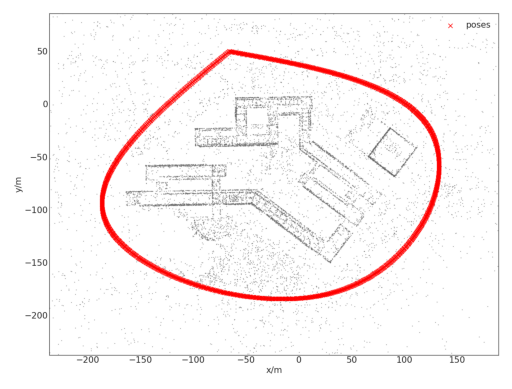

In [318]:
video_path = os.path.join(lp.model_path, filename, "ours_lod_video")
makedirs(video_path, exist_ok=True)
frames = []
pose_per_segment = 300

# second parameter appoints number of points interpolated between each consecutive points to draw the curve
interp_xyz, _ = evaluate_bezier_v3(pose_centers, pose_per_segment)
xyz_pre = None

fontsize = 20
fig = plt.Figure(figsize=(16, 12), dpi=76)
fig.set_tight_layout(True)
canvas = FigureCanvasAgg(fig)
ax = fig.gca()
gs_xyz = gaussians.get_xyz.cpu().detach().numpy()
ax.scatter(gs_xyz[::200, 0], gs_xyz[::200, dim], c='dimgrey', s=0.5)
# ax.plot(cam_center_array[simplified_hull,0], cam_center_array[simplified_hull, dim], 'r--^',lw=2)
ax.axis('equal')
ax.set_xlabel('x/m', fontsize=fontsize)
ax.set_ylabel('y/m', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_xlim(np.min(cam_center_array[:, 0]), np.max(cam_center_array[:, 0]))
ax.set_ylim(np.min(cam_center_array[:, dim]), np.max(cam_center_array[:, dim]))

plt.style.use('seaborn-white')
for t in range(len(interp_xyz)):
    xyz = interp_xyz[t]
    xyz[1] = pose2_center[1] + 35

    if t == 0:
        delta = interp_xyz[t + 1] - interp_xyz[t]
    else:
        delta = xyz - xyz_pre
    
    if not np.any(delta):
        continue
    
    ax.scatter(xyz[0], xyz[dim], s=100, c='r', marker='x', label='poses')
    if t == 0:
        ax.legend(fontsize=fontsize)
    # canvas.draw()
    # buf = canvas.buffer_rgba()
    # bev_map = np.asarray(buf)[..., :3]

    angle = np.arctan2(delta[dim], delta[0])
    # angle = np.arctan2(delta[0], -delta[dim])  # for building

    viewpoint_cam = loadCamV3(lp, idx, poses[0], 1.0, xyz=xyz, z_dim=1, yaw=angle)
    img = render(viewpoint_cam, gaussians, pp, background)["render"]
    img = (img * 255).clamp(0, 255).to(torch.uint8).permute(1, 2, 0).cpu().numpy()

    # img = np.concatenate([img, bev_map], axis=1)
    
    frames.append(img)

    xyz_pre = xyz

canvas.draw()
buf = canvas.buffer_rgba()
bev_map = np.asarray(buf)[..., :3]
plt.imshow(bev_map)
plt.axis('off')

In [319]:
video = imageio.get_writer(os.path.join(video_path, "video.mp4"), mode="I", fps=30, codec="libx264", bitrate="16M", quality=10)
for frame in frames:
    video.append_data(frame)
video.close()
print(f'Video saved to {video_path}')

Video saved to ../output/block_sciart_all_lr_c9_loss_5_r4/train/ours_lod_video


## 2. Zoom Out

In [ ]:
video_path = os.path.join(model_path, config_name, "ours_lod_video")
makedirs(video_path, exist_ok=True)

idx = 481
pitch = -180.0
duration_list = []
frames = []

for height in tqdm(range(500, 2500, 15)):

    viewpoint_cam = loadCamV2(lp, idx, views[idx], 1.0, pitch, float(2500)/100)

    start = time.time()
    img = render_lod(viewpoint_cam, lod_gs_list, pp, background)["render"]
    img = (img * 255).clamp(0, 255).to(torch.uint8).permute(1, 2, 0).cpu().numpy()
    end = time.time()
    frames.append(img)
    duration_list.append(end - start)

In [10]:
video = imageio.get_writer(os.path.join(video_path, "video.mp4"), mode="I", fps=36, codec="libx264", bitrate="16M", quality=10)
for frame in frames:
    video.append_data(frame)
video.close()
print(f'Video saved to {video_path}')

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1600, 900) to (1600, 912) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video saved to ../output/block_mc_aerial_block_all_lr_c36_loss_5_lod/block_mc_aerial_block_all_lr_c36_loss_5_75_lr64_vq/ours_lod_video
